In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler
from scipy.sparse import coo_matrix, csr_matrix

Read in standardized csv files and merge them into one Dataframe with relevant information

In [224]:
df_form = pd.read_csv("formationout.csv")
df_well = pd.read_csv("out.csv")
#Merge the 2 CSVs by API number
df_merged = df_well.merge(df_form, how = "left", on = "API Number")
#drop well number identifier since we are using API number
df_merged.drop(columns="Well Number", inplace = True)

Standardize depth around the minimum value

In [225]:
df_merged["Top MD"] = df_merged["Top MD"] - df_merged["Top MD"].min()

Taking a sample of the Dataframe to holdout 

In [226]:
df_holdout = df_merged.sample(frac=0.2, random_state=4242001)
#make list of API numbers that we held out
heldout_APIs = []
for i in df_holdout["API Number"]:
    heldout_APIs.append(i)
#now we need to go back to our original Dataframe and set the vals we are holding out to 0
df_merged_heldout = df_merged.copy()
np.random.seed(4242001)
#get 5 random formation aliases to hold out
h = np.random.randint(0, 59, 5)
#hold out these tops by setting them to NaN, but keep the rest of the data intact
df_merged_heldout[df_merged_heldout["API Number"].isin(heldout_APIs)]["Form Alias"].replace(h, float("NaN"), inplace=True)

Sort the held out values by API Number and Formation Alias

In [227]:
df_holdout.sort_values(by=["API Number", "Form Alias"], inplace=True)

Make a sparse matrix from the Dataframe with random formation aliases held out

In [228]:
D_df = df_merged_heldout.pivot_table("Top MD","Form Alias","API Number").fillna(0)
D_df

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,1342.21,1560.38,1441.13,1691.06,1836.97,1561.61,0.00,1678.26,1419.08,1547.05,...,0.00,1043.260,955.85,1256.410,0.000,1033.620,1792.54,907.740,898.69,0.00
1.0,978.64,1186.67,1086.90,1319.30,1467.37,1197.77,0.00,1319.98,1042.02,1171.76,...,0.00,0.000,0.00,879.090,0.000,0.000,1345.67,0.000,0.00,0.00
2.0,929.11,1138.35,1039.96,1270.49,1420.05,1152.29,0.00,1276.88,993.83,1124.42,...,0.00,0.000,0.00,834.630,0.000,0.000,1299.08,0.000,0.00,0.00
3.0,1428.70,1646.16,1528.31,1778.43,1928.16,1648.34,0.00,1768.68,1507.01,1634.11,...,0.00,1124.700,1039.67,1350.490,0.000,1121.070,1870.81,994.840,985.07,0.00
4.0,0.00,0.00,1600.85,1849.07,1996.05,1718.14,0.00,1839.66,0.00,1704.27,...,0.00,1200.560,1111.40,0.000,0.000,1194.170,1949.07,1069.040,1059.00,0.00
5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2555.960,0.00,2766.850,2641.530,2537.770,0.00,2441.000,2476.86,0.00
6.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2775.950,0.00,3001.600,2874.500,2779.960,0.00,2677.000,2700.55,2720.50
7.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,2996.800,2890.91,3226.050,3099.135,2997.750,0.00,2905.000,2921.18,2945.85
8.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,3228.010,3130.05,3468.600,3346.945,3241.720,0.00,3153.840,3157.86,3188.13


Trying different ways of normalizing R, demeaning and normalizing with SKLearn

In [229]:
mms = MinMaxScaler()
R = D_df.values
target_vals = df_holdout["Top MD"]
R_normalize = mms.fit_transform(R, target_vals)

Create binarized matrix with values of 1 where there are depth values in the sparse matrix R and values of 0 where there are not depth values in the sparse matrix R.

In [230]:
from sklearn.preprocessing import binarize
A = binarize(R)

This is the code that runs Alternating Least Squares factorization

In [231]:
#ALS factorization from 
# https://github.com/mickeykedia/Matrix-Factorization-ALS/blob/master/ALS%20Python%20Implementation.py
# here items are the formation and users are the well
def runALS(A, R, n_factors, n_iterations, lambda_):
    """
    Runs Alternating Least Squares algorithm in order to calculate matrix.
    :param A: User-Item Matrix with ratings
    :param R: User-Item Matrix with 1 if there is a rating or 0 if not
    :param n_factors: How many factors each of user and item matrix will consider
    :param n_iterations: How many times to run algorithm
    :param lambda_: Regularization parameter
    :return:
    """
    print("Initiating ")
    lambda_ = lambda_
    n_factors = n_factors
    n, m = A.shape
    n_iterations = n_iterations
    Users = 5 * np.random.rand(n, n_factors)
    Items = 5 * np.random.rand(n_factors, m)

    def get_error(A, Users, Items, R):
        # This calculates the MSE of nonzero elements
        return np.sum((R * (A - np.dot(Users, Items))) ** 2) / np.sum(R)

    MSE_List = []

    print("Starting Iterations")
    for iter in range(n_iterations):
        for i, Ri in enumerate(R):
            Users[i] = np.linalg.solve(
                np.dot(Items, np.dot(np.diag(Ri), Items.T))
                + lambda_ * np.eye(n_factors),
                np.dot(Items, np.dot(np.diag(Ri), A[i].T)),
                ).T
        print(
            "Error after solving for User Matrix:",
            get_error(A, Users, Items, R),
            )

        for j, Rj in enumerate(R.T):
            Items[:, j] = np.linalg.solve(
                np.dot(Users.T, np.dot(np.diag(Rj), Users))
                + lambda_ * np.eye(n_factors),
                np.dot(Users.T, np.dot(np.diag(Rj), A[:, j])),
                )
        print(
            "Error after solving for Item Matrix:",
             get_error(A, Users, Items, R),
            )

        MSE_List.append(get_error(A, Users, Items, R))
        print("%sth iteration is complete..." % iter)
    return Users, Items
    
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # plt.plot(range(1, len(MSE_List) + 1), MSE_List); plt.ylabel('Error'); plt.xlabel('Iteration')
    # plt.title('Python Implementation MSE by Iteration \n with %d formations and %d wells' % A.shape);
    # plt.savefig('Python MSE Graph.pdf', format='pdf')
    # plt.show()

Get the User and Item vectors from ALS

In [232]:
U, Vt = runALS(R, A, 20, 20, 0.1)

Initiating 
Starting Iterations
Error after solving for User Matrix: 124314.678923345
Error after solving for Item Matrix: 92.74020476105458
0th iteration is complete...
Error after solving for User Matrix: 59.49098637987175
Error after solving for Item Matrix: 24.000604268138247
1th iteration is complete...
Error after solving for User Matrix: 18.518762437346936
Error after solving for Item Matrix: 9.868661034179697
2th iteration is complete...
Error after solving for User Matrix: 8.824648181112142
Error after solving for Item Matrix: 4.798700186023154
3th iteration is complete...
Error after solving for User Matrix: 5.2878271008059246
Error after solving for Item Matrix: 3.0257462581100723
4th iteration is complete...
Error after solving for User Matrix: 3.6982032503484588
Error after solving for Item Matrix: 2.2515395510738743
5th iteration is complete...
Error after solving for User Matrix: 2.992952156456225
Error after solving for Item Matrix: 1.8172446709870291
6th iteration is c

Construct our predicted Dataframe from our User and Item vectors

In [234]:
recommendations = np.dot(U, Vt)
recsys_df = pd.DataFrame(data = recommendations[0:, 0:], index = D_df.index,
                        columns = D_df.columns)
recsys_df.head()

API Number,490250632500,490250632700,490250632800,490250632900,490250633200,490250633400,490250633800,490250633900,490250634000,490250634100,...,490252284701,490252303100,490252304000,490252304700,490252304800,490252305400,490252305500,490252319500,490252345102,490252347904
Form Alias,,,,,,,,,,,,,,,,,,,,,
0.0,1342.087951,1560.181981,1440.985375,1690.834855,1836.718296,1561.426165,1049.729924,1678.057259,1418.938669,1546.870221,...,1025.251811,1042.402887,955.544617,1254.631194,1149.467182,1031.967555,1792.231912,908.497167,898.703696,1014.109107
1.0,978.595934,1186.624670,1086.857157,1319.248414,1467.319391,1197.727294,761.806169,1319.941185,1041.979135,1171.714959,...,842.625004,772.298732,645.290540,878.508677,882.575080,722.372793,1345.622955,589.988025,700.979402,826.115219
2.0,929.173359,1138.410584,1040.018005,1270.552613,1420.107558,1152.345816,751.921600,1276.928306,993.889979,1124.480057,...,820.533872,716.129255,579.823728,836.409017,881.827481,719.537124,1299.144954,578.270620,684.154344,804.401038
3.0,1428.786861,1646.318349,1528.410251,1778.597729,1928.345867,1648.472199,1134.883305,1768.827314,1507.114091,1634.238037,...,1119.626125,1126.334439,1041.980703,1349.396243,1242.928439,1120.627525,1871.060456,997.882096,985.095264,1105.794447
4.0,1508.860596,1732.320148,1600.859133,1849.086775,1996.074478,1718.153664,1218.178992,1839.677426,1589.507213,1704.282848,...,1189.586662,1199.817812,1110.508856,1391.065661,1295.240447,1195.229925,1949.075379,1064.601416,1058.983431,1189.224612


Reshape the predicted Dataframe to a more easily accessible format

In [235]:
recsys_df_reshaped = recsys_df.T.reset_index()

Reshape our predictions and merge them into one final Dataframe showcasing the relevant information 

In [252]:
#reshape predictions
flat_preds = recsys_df.unstack().reset_index()
#merge predictions with our testing data set
merged_df = pd.merge(df_holdout, flat_preds,  how='left', left_on=['API Number','Form Alias'], right_on = ['API Number','Form Alias'])
merged_df.rename(columns={0:"Predicted Depth"}, inplace=True)
#Drop irrelevant columns to more clearly showcase results
final_df = merged_df.drop(columns={"Northing", "Easting", "Normalized TVD", "True Vertical Depth"})
#add signed error colum to indicate whether we are over or under predicting
final_df["signed_error"] = final_df["Top MD"] - final_df["Predicted Depth"]
final_df.dropna().head()

,API Number,Form Alias,Top MD,Predicted Depth,signed_error
1,490250632500,1.0,978.64,978.595934,0.044066
2,490250632700,3.0,1646.16,1646.318349,-0.158349
3,490250632800,2.0,1039.96,1040.018005,-0.058005
4,490250632800,3.0,1528.31,1528.410251,-0.100251
5,490250633200,1.0,1467.37,1467.319391,0.050609


Now from our final Dataframe we can find an error metric to evaluate the performance of our model.

In [249]:
from sklearn.metrics import mean_absolute_error as MAE
MAE(final_df["Top MD"].dropna().values, final_df["Predicted Depth"].dropna().values)

1.0147430706752893

Plot the recommended depths for all formations for the first 5 wells vs the actual depths

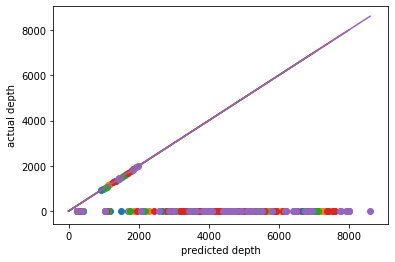

In [250]:
for i in range(5):
    plt.scatter(recsys_df.iloc[0:, i].values, D_df.iloc[0:, i].values) #plot predicted vs actual
    plt.xlabel('predicted depth')
    plt.ylabel('actual depth')
    plt.plot(np.arange(0,recsys_df.iloc[0:,i].max()))